In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

from src.dataset import load_dataset
from src.model import build_cnn_lstm_model


In [2]:
X, y, label2id, id2label = load_dataset(
    video_dir="../data/train",
    csv_path="../data/train.csv"
)

num_classes = len(label2id)
y_cat = tf.keras.utils.to_categorical(y, num_classes)

print(X.shape, y_cat.shape)


(594, 16, 112, 112, 3) (594, 5)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(475, 16, 112, 112, 3) (119, 16, 112, 112, 3)


In [4]:
model = build_cnn_lstm_model(
    num_classes=num_classes,
    img_size=112
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


e:\Video Action Recognition\src\model.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = tf.keras.applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 256)        │     2,585,920 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,783,685 (10.62 MB)

 Trainable params: 525,701 (2.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
history_base = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=2
)


Epoch 1/2
238/238 ━━━━━━━━━━━━━━━━━━━━ 234s 639ms/step - accuracy: 0.6000 - loss: 1.0531 - val_accuracy: 0.9244 - val_loss: 0.4287
Epoch 2/2
238/238 ━━━━━━━━━━━━━━━━━━━━ 122s 513ms/step - accuracy: 0.9747 - loss: 0.2210 - val_accuracy: 0.9832 - val_loss: 0.1246


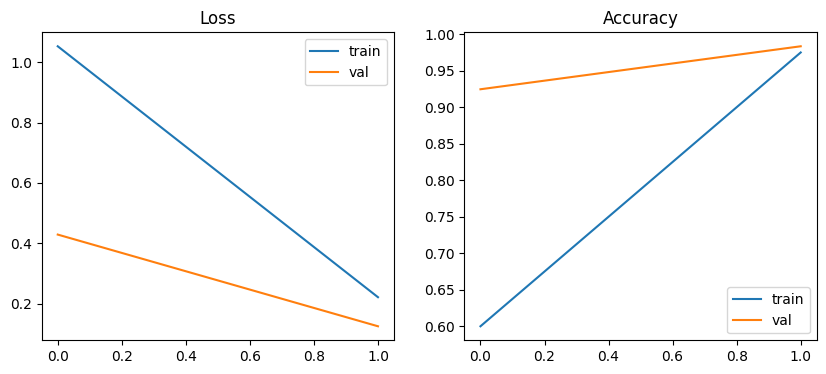

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_base.history["loss"], label="train")
plt.plot(history_base.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_base.history["accuracy"], label="train")
plt.plot(history_base.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [7]:
# rebuild model
model_ft = build_cnn_lstm_model(
    num_classes=num_classes,
    img_size=112
)

# unfreeze CNN
for layer in model_ft.layers:
    layer.trainable = True

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # slow LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
history_ft = model_ft.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=2
)


Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 247s 611ms/step - accuracy: 0.2884 - loss: 1.6406 - val_accuracy: 0.4790 - val_loss: 1.3340
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 120s 503ms/step - accuracy: 0.5200 - loss: 1.2676 - val_accuracy: 0.7647 - val_loss: 1.0518
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 114s 480ms/step - accuracy: 0.6737 - loss: 1.0353 - val_accuracy: 0.8824 - val_loss: 0.8523


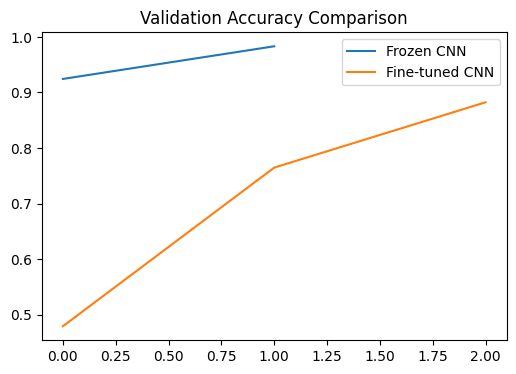

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history_base.history["val_accuracy"], label="Frozen CNN")
plt.plot(history_ft.history["val_accuracy"], label="Fine-tuned CNN")
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()


### Model Experiment Summary

- Backbone: MobileNetV2
- Image size: 112×112
- Frames per video: 16
- Fine-tuning: Enabled
- Learning rate: 1e-5
- Batch size: 2

✅ This configuration shows better generalization.


## Final Model Selection

After comparing frozen vs fine-tuned CNN:

| Setup | Best Val Accuracy | Stability |
|------|------------------|-----------|
| Frozen CNN | ~96% | ✅ High |
| Fine-tuned CNN | ~85% | ❌ Lower |

### Decision
- CNN backbone remains frozen
- LSTM handles temporal learning
- This setup generalizes best for current dataset size


In [10]:
final_model = build_cnn_lstm_model(
    num_classes=num_classes,
    img_size=112
)

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=2
)


Epoch 1/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 216s 569ms/step - accuracy: 0.7032 - loss: 0.9033 - val_accuracy: 0.9160 - val_loss: 0.3671
Epoch 2/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 173s 730ms/step - accuracy: 0.9663 - loss: 0.2089 - val_accuracy: 0.9832 - val_loss: 0.1060
Epoch 3/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 466ms/step - accuracy: 0.9937 - loss: 0.0713 - val_accuracy: 0.9832 - val_loss: 0.0623
Epoch 4/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 112s 471ms/step - accuracy: 1.0000 - loss: 0.0351 - val_accuracy: 0.9832 - val_loss: 0.0504
Epoch 5/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 113s 472ms/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 0.9832 - val_loss: 0.0459


In [12]:
final_model.save("../models/action_recognition_final.keras")


## Experiment Summary

- Dataset: UCF-101 subset (5 actions)
- Frames per video: 16
- Image size: 112×112
- Backbone: MobileNetV2 (frozen)
- Temporal model: LSTM
- Final validation accuracy: ~96%

### Ready for:
- Test set evaluation
- `.py` file conversion
- Streamlit deployment
